# Procedure

Like in Table 1 in https://www.pnas.org/doi/10.1073/pnas.1708800115#supplementary-materials, I do the following:

Split data in training and testing data and train a linear regression for each of the nine CCs by training on the other eight.
Calculate the coefficient of prediction $\rho^2 = 1 - \frac{ \sum (Y_i^* - Y_i)^2 }{ \sum (\bar{Y} - Y_i)^2}$ that compares prediction $Y_i^*$ to using the mean $\bar{Y}$. Then, repeat the same with the eight CCs AND using RelTime and see if $\rho^2$ improves (i.e. increases) or not. We use several train-test-splits and calculate the mean $\rho^2$.

First do this for the entire data set, then only for the cutout values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
import random
random.seed(42)
n_CVal = 10000

In [2]:
def RhoSq(y_hat, y_true):
    y_mean = np.mean(y_true)
    return(1 - sum((y_hat-y_true)**2)/sum((y_mean-y_true)**2)  )

In [3]:
DF_Cut = pd.read_csv("Cutouts_CC_with_Reltime.csv", index_col=0)
DF_Full = pd.read_csv("RelTime_TimeSeries_CC.csv", index_col=0)
DF_Full

,NGA,RelTime,SPC1,PolPop,PolTerr,CapPop,levels,government,infrastr,writing,texts,money
0,Orkhon Valley,-1900,0.315541,4.552769,5.591893,4.007285,2.587429,0.100000,0.075000,0.200000,0.1000,1.0
1,Orkhon Valley,-1800,0.315541,4.552769,5.591893,4.007285,2.587429,0.100000,0.075000,0.200000,0.1000,1.0
2,Orkhon Valley,-1700,0.315541,4.552769,5.591893,4.007285,2.587429,0.100000,0.075000,0.200000,0.1000,1.0
3,Orkhon Valley,-1600,0.315541,4.552769,5.591893,4.007285,2.587429,0.100000,0.075000,0.200000,0.1000,1.0
4,Orkhon Valley,-1500,0.315541,4.552769,5.591893,4.007285,2.587429,0.100000,0.075000,0.200000,0.1000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
766,Kansai,1000,0.819800,7.096910,5.469822,5.176091,5.909872,0.690000,0.916667,1.000000,0.9875,4.0
767,Kansai,1100,0.746661,7.230449,4.176091,4.602060,5.083771,0.490000,0.840000,0.985714,0.9250,5.0
768,Kansai,1200,0.824980,7.397940,5.469822,5.000000,5.244956,0.710000,0.925000,0.983333,0.9875,5.0
769,Kansai,1300,0.923083,7.462398,5.469822,6.113943,6.534359,0.857143,1.000000,1.000000,1.0000,6.0


In [4]:
del DF_Cut["NGA"]
del DF_Cut["SPC1"]
del DF_Full["NGA"]
del DF_Full["SPC1"]

In [5]:
X_Full =DF_Full.copy()
del X_Full["PolPop"]
X_train, X_test, y_train, y_test  = train_test_split(X_Full, DF_Full["PolPop"],
                                                    random_state = 42)

In [6]:
lr_RelTime = LR().fit(X_train, y_train)
y_hat = lr_RelTime.predict(X_test)


In [7]:
RhoSq(y_hat, y_test) 

0.8992602915402733

### And now, without RelTime

In [8]:
del X_Full["RelTime"]
X_train, X_test, y_train, y_test  = train_test_split(X_Full, DF_Full["PolPop"],
                                                    random_state = 42)
lr_NoTime = LR().fit(X_train, y_train)
y_hat_no = lr_NoTime.predict(X_test)
RhoSq(y_hat_no, y_test)

0.8944725299875799

In [9]:
CCs = DF_Full.columns
CCs = CCs[1:] # Do not train to predict RelTime
print(CCs)

Index(['PolPop', 'PolTerr', 'CapPop', 'levels', 'government', 'infrastr',
       'writing', 'texts', 'money'],
      dtype='object')


In [10]:
List_RhoSq_t = list()
List_RhoSq_not = list()

for i in range(n_CVal):
    
    c = random.randint(0,len(CCs)-1)
    Target = CCs[c] # regression target

    y = DF_Cut[Target]
    X = DF_Cut.copy()
    del X[Target]
    
    
    X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                    random_state = i)
    # With time
    LR_t = LR().fit(X_train, y_train)
    y_hat = LR_t.predict(X_test)
    List_RhoSq_t.append(RhoSq(y_hat, y_test)) 
    
    # without time
    del X["RelTime"]
    
    X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                    random_state = i)
    LR_no = LR().fit(X_train, y_train)
    y_hat = LR_no.predict(X_test)
    List_RhoSq_not.append(RhoSq(y_hat, y_test) )

In [11]:
Difference = np.array(List_RhoSq_t) -  np.array(List_RhoSq_not)

In [12]:
np.mean(Difference), np.std(Difference)

(0.002338046135108548, 0.005915843091870299)

(array([1.000e+00, 5.000e+00, 2.700e+01, 1.350e+02, 1.370e+03, 6.798e+03,
        1.006e+03, 4.760e+02, 1.590e+02, 2.300e+01]),
 array([-0.03810828, -0.03079211, -0.02347593, -0.01615976, -0.00884359,
        -0.00152741,  0.00578876,  0.01310493,  0.02042111,  0.02773728,
         0.03505345]),
 <BarContainer object of 10 artists>)

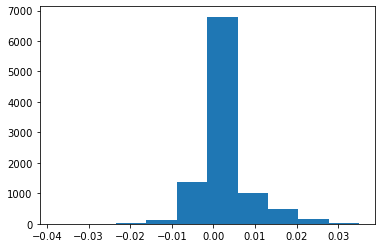

In [13]:
plt.hist(Difference)